# Food Vision Project

In [1]:
import tensorflow as tf

# Setup gpu drivers
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [2]:
# Get helper functions file
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

### Use TensorFlow Datasets to Download Data

In [4]:
import tensorflow_datasets as tfds

In [5]:
# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

2023-07-14 19:37:46.175398: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


'food101' in TensorFlow Datasets: True


In [6]:
# Load the data
(train_data, test_data), ds_info = tfds.load(
    name="food101", # target dataset to get from TFDS
    split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
    shuffle_files=True, # shuffle files on download?
    as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
    with_info=True, # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info) 
)

2023-07-14 19:37:49.440177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 19:37:49.441134: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 data from TensorFlow Datasets

In [9]:
# Take one sample off the training data
train_one_sample = train_data.take(1)

In [10]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info about our training sample
for image, label in train_one_sample:
    print(f"""
        Image shape: {image.shape}
        Image dtype: {image.dtype}
        Target class from Food101 (tensor form): {label}
        Class name (str form): {class_names[label.numpy()]}
    """)


        Image shape: (512, 384, 3)
        Image dtype: <dtype: 'uint8'>
        Target class from Food101 (tensor form): 19
        Class name (str form): chicken_quesadilla
    


In [12]:
image

<tf.Tensor: shape=(512, 384, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  7,   7,   5],
        [ 11,  11,   9],
        [ 14,  14,  12]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  5,   5,   3],
        [  8,   8,   6],
        [ 11,  11,   9]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  5,   5,   3],
        [  7,   7,   5],
        [ 10,  10,   8]],

       ...,

       [[ 72,  75,  82],
        [ 55,  58,  65],
        [ 43,  46,  51],
        ...,
        [105, 113, 115],
        [108, 113, 116],
        [135, 140, 143]],

       [[ 75,  80,  86],
        [ 61,  66,  72],
        [ 51,  54,  59],
        ...,
        [102, 107, 110],
        [ 75,  79,  82],
        [111, 115, 118]],

       [[ 94,  99, 105],
        [ 81,  86,  92],
        [ 71,  74,  79],
        ...,
        [151, 156, 15

In [13]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

#### Plot an image from TensorFlow Datasets

(-0.5, 383.5, 511.5, -0.5)

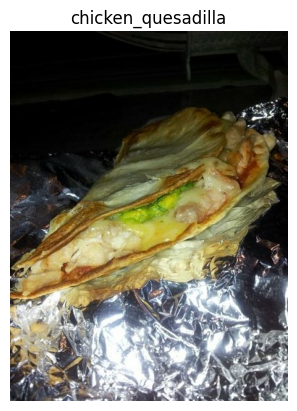

In [14]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False)

### Create preprocessing functions for our data

In [15]:
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [16]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 7  7  5]
  [11 11  9]
  [14 14 12]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 5  5  3]
  [ 8  8  6]
  [11 11  9]]]...,
Shape: (512, 384, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  ...
  [ 7.7907934  7.7907934  5.7907934]
  [ 5.714286   5.714286   3.7142856]
  [10.999987  10.999987   8.999987 ]]

 [[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  ...
  [ 6.770399   6.770399   4.770399 ]
  [ 6.790833   6.790833   4.790833 ]
  [10.1887665 10.1887665  8.1887665]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


(-0.5, 223.5, 223.5, -0.5)

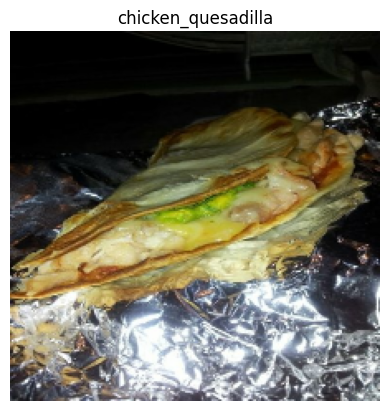

In [17]:
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False)

### Batch & prepare datasets

In [18]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

#### Create modelling callbacks

In [20]:
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

#### Setup mixed precision training

In [21]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [22]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [23]:
policy = tf.keras.mixed_precision.Policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

### Build feature extraction model

In [24]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [25]:
# Check out our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

#### Checking layer dtype policies

In [26]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "float32">
pooling_layer True float32 <Policy "float32">
dense True float32 <Policy "float32">
softmax_float32 True float32 <Policy "float32">


In [27]:
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
tf.math.truediv False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">


### Fit the feature extraction model

In [28]:
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(
    train_data, 
    epochs=3,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[
        create_tensorboard_callback(
            "training_logs", 
            "efficientnetb0_101_classes_all_data_feature_extract"),
        model_checkpoint
    ]
)

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230714-193756
Epoch 1/3
2368/2368 [==============================] - 800s 336ms/step - loss: 1.7193 - accuracy: 0.5814 - val_loss: 1.1321 - val_accuracy: 0.7021
Epoch 2/3
2368/2368 [==============================] - 787s 332ms/step - loss: 1.2008 - accuracy: 0.6885 - val_loss: 1.0196 - val_accuracy: 0.7169
Epoch 3/3
2368/2368 [==============================] - 775s 327ms/step - loss: 1.0538 - accuracy: 0.7239 - val_loss: 0.9963 - val_accuracy: 0.7225


In [29]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 254s 322ms/step - loss: 1.0058 - accuracy: 0.7250


[1.0058226585388184, 0.7249900698661804]

#### Load and evaluate checkpoint weights

In [30]:
# 1. Create a function to recreate the original model
def create_model():
    # Create base model
    input_shape = (224, 224, 3)
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
    base_model.trainable = False # freeze base model layers

    # Create Functional model 
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = base_model(inputs, training=False) # set base_model to inference mode only
    x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
    x = layers.Dense(len(class_names))(x) # want one output neuron per class 
    # Separate activation of output layer so we can output float32 activations
    outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
    model = tf.keras.Model(inputs, outputs)
  
    return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

790/790 [==============================] - 244s 307ms/step - loss: 1.0058 - accuracy: 0.7250


In [31]:
import numpy as np
assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."

In [32]:
# Check the layers in the base model and see what dtype policy they're using
for layer in created_model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "float32">
normalization_1 False float32 <Policy "float32">
tf.math.truediv_1 False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">


#### Save the whole model to file

In [33]:
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [34]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [35]:
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "float32">
normalization False float32 <Policy "float32">
tf.math.truediv False float32 <Policy "float32">
stem_conv_pad False float32 <Policy "float32">
stem_conv False float32 <Policy "float32">
stem_bn False float32 <Policy "float32">
stem_activation False float32 <Policy "float32">
block1a_dwconv False float32 <Policy "float32">
block1a_bn False float32 <Policy "float32">
block1a_activation False float32 <Policy "float32">
block1a_se_squeeze False float32 <Policy "float32">
block1a_se_reshape False float32 <Policy "float32">
block1a_se_reduce False float32 <Policy "float32">
block1a_se_expand False float32 <Policy "float32">
block1a_se_excite False float32 <Policy "float32">
block1a_project_conv False float32 <Policy "float32">
block1a_project_bn False float32 <Policy "float32">
block2a_expand_conv False float32 <Policy "float32">
block2a_expand_bn False float32 <Policy "float32">


In [36]:
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 249s 314ms/step - loss: 1.0058 - accuracy: 0.7250


[1.0058223009109497, 0.7249900698661804]

In [37]:
assert np.isclose(results_feature_extract_model, results_loaded_saved_model).all()

### Preparing our model's layers for fine-tuning

In [38]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2023-07-14 20:30:15--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2800:3f0:4004:810::2010, 2800:3f0:4004:804::2010, 2800:3f0:4004:800::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2800:3f0:4004:810::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16,19M  10,8MB/s    in 1,5s    

2023-07-14 20:30:17 (10,8 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [39]:
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [40]:
loaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [41]:
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [42]:
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 3092s 4s/step - loss: nan - accuracy: 0.0099


[nan, 0.009900989942252636]

In [43]:
for layer in loaded_gs_model.layers:
    layer.trainable = True # set all layers to trainable
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # make sure loaded model is using mixed precision dtype_policy ("mixed_float16")

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [44]:
for layer in loaded_gs_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

#### A couple more callbacks

In [45]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", # watch the val loss metric
    patience=3 # if val loss decreases for 3 epochs in a row, stop training
) 

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=True,
    monitor="val_loss"
)

In [46]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",  
    factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
    patience=2,
    verbose=1, # print out when learning rate goes down 
    min_lr=1e-7
)

In [47]:
# Compile the model
loaded_gs_model.compile(
    loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
    optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
    metrics=["accuracy"]
)

In [48]:
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(
    train_data,
    epochs=100, # fine-tune for a maximum of 100 epochs
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
    callbacks=[
        create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
        model_checkpoint, # save only the best model during training
        early_stopping, # stop model after X epochs of no improvements
        reduce_lr # reduce the learning rate after X epochs of no improvements
    ] 
)

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20230714-212156
Epoch 1/100
2368/2368 [==============================] - 28669s 12s/step - loss: nan - accuracy: 0.0099 - val_loss: nan - val_accuracy: 0.0072 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0099 
Epoch 2: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 28653s 12s/step - loss: nan - accuracy: 0.0099 - val_loss: nan - val_accuracy: 0.0069 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 28697s 12s/step - loss: nan - accuracy: 0.0099 - val_loss: nan - val_accuracy: 0.0072 - lr: 2.0000e-05


In [49]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
loaded_gs_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

#### Download fine-tuned model from Google Storage

In [50]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip

--2023-07-15 21:15:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2800:3f0:4001:829::2010, 2800:3f0:4001:82a::2010, 2800:3f0:4001:82b::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2800:3f0:4001:829::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46790356 (45M) [application/zip]
Saving to: ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  44,62M  18,2MB/s    in 2,5s    

2023-07-15 21:16:01 (18,2 MB/s) - ‘07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip’ saved [46790356/46790356]



In [51]:
!mkdir downloaded_fine_tuned_gs_model # create separate directory for fine-tuned model downloaded from Google Storage
!unzip 07_efficientnetb0_fine_tuned_101_classes_mixed_precision -d downloaded_fine_tuned_gs_model

Archive:  07_efficientnetb0_fine_tuned_101_classes_mixed_precision.zip
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/variables/variables.index  
  inflating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/saved_model.pb  
   creating: downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets/


In [52]:
# Load in fine-tuned model from Google Storage and evaluate
loaded_fine_tuned_gs_model = tf.keras.models.load_model("downloaded_fine_tuned_gs_model/07_efficientnetb0_fine_tuned_101_classes_mixed_precision")

In [53]:
loaded_fine_tuned_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

In [54]:
# Note: Even if you're loading in the model from Google Storage, you will still need to load the test_data variable for this cell to work
results_downloaded_fine_tuned_gs_model = loaded_fine_tuned_gs_model.evaluate(test_data)
results_downloaded_fine_tuned_gs_model

790/790 [==============================] - 3024s 4s/step - loss: nan - accuracy: 0.0099


[nan, 0.009900989942252636]

### View training results on TensorBoard

In [55]:
!tensorboard dev upload --logdir ./training_logs \
    --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
    --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
    --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Ek5c7ZBaT4O1Bf17AyxXUw/

[2023-07-15T22:06:38] Started scanning logdir.
[2023-07-15T22:06:42] Total uploaded: 36 scalars, 0 tensors, 3 binary objects (2.7 MB)
[2023-07-15T22:06:42] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/Ek5c7ZBaT4O1Bf17AyxXUw/


In [56]:
!tensorboard dev list

https://tensorboard.dev/experiment/Ek5c7ZBaT4O1Bf17AyxXUw/
	Name                 Fine-tuning EfficientNetB0 on all Food101 Data
	Description          Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001
	Id                   Ek5c7ZBaT4O1Bf17AyxXUw
	Created              2023-07-15 22:06:38 (8 seconds ago)
	Updated              2023-07-15 22:06:42 (just now)
	Runs                 5
	Tags                 5
	Scalars              36
	Tensor bytes         0
	Binary object bytes  2821028
https://tensorboard.dev/experiment/vaWq857kRVaBOk9NpqZ5tQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   vaWq857kRVaBOk9NpqZ5tQ
	Created              2023-07-09 04:08:13
	Updated              2023-07-09 04:08:17
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object byt

In [58]:
!tensorboard dev delete --experiment_id vaWq857kRVaBOk9NpqZ5tQ

Deleted experiment vaWq857kRVaBOk9NpqZ5tQ.
